In [1]:
import rioxarray as rxr
import rasterio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# --- Archivos ---
SLOPE_TIF = "/home/aninotna/magister/tesis/justh2_pipeline/data/srtm/slope_deg_aconcagua.tif"
LAND_OK_TIF = "land_ok_2022.tif"


In [3]:
# 1) Cargar slope
slope = rxr.open_rasterio(SLOPE_TIF, masked=True).squeeze()


In [4]:
# 2) Cargar land_ok
land_ok = rxr.open_rasterio(LAND_OK_TIF, masked=True).squeeze()


In [5]:
# 3) Reproyectar land_ok para que calce con slope
land_ok = land_ok.rio.reproject_match(
    slope,
    resampling=rasterio.enums.Resampling.nearest,
    nodata=0
)

In [6]:
# 4) Filtrar pendiente (< umbral)
THRESHOLD_DEG = 10
slope_ok = slope < THRESHOLD_DEG


In [7]:
# 5) Combinar: pendiente baja Y uso de suelo permitido
suitable = xr.where((slope_ok & (land_ok == 1)), 1, 0)


In [8]:
# 6) Calcular área en hectáreas
res_x, res_y = slope.rio.resolution()   # tamaño de pixel en metros
pixel_area_m2 = abs(res_x * res_y)
pixel_area_ha = pixel_area_m2 / 10000.0

total_pixels = int((suitable.values == 1).sum())
total_area_ha = total_pixels * pixel_area_ha

print(f"✅ Área apta: {total_area_ha:,.2f} ha")


✅ Área apta: 332,413.32 ha


In [9]:
# 7) Exportar a GeoTIFF
suitable = suitable.rio.write_crs(slope.rio.crs)
suitable = suitable.rio.set_spatial_dims(x_dim="x", y_dim="y")
suitable.rio.to_raster("suitable_pv_2022.tif")


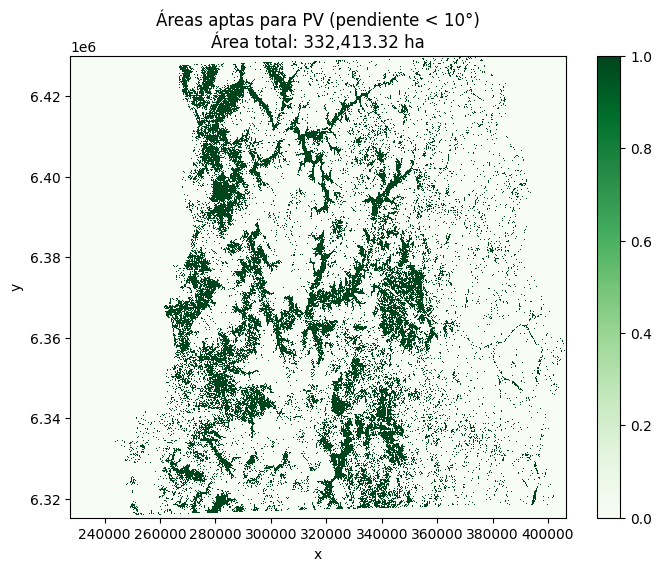

In [10]:
# 8) Graficar
plt.figure(figsize=(8, 6))
suitable.plot(cmap="Greens", add_colorbar=True)
plt.title(f"Áreas aptas para PV (pendiente < {THRESHOLD_DEG}°)\nÁrea total: {total_area_ha:,.2f} ha")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [11]:
total_area_km2 = total_area_ha / 100.0
energy_cap_max_MW = total_area_km2 * 60
print(f"Potencial técnico PV: {energy_cap_max_MW:,.2f} MW")


Potencial técnico PV: 199,447.99 MW
